<a href="https://colab.research.google.com/github/SOL1archive/KoGrammar/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
  
except:
  IN_COLAB = False

IN_COLAB

False

In [2]:
if IN_COLAB:
    !pip install transformers
    !pip install datasets
    !pip install evaluate
    !pip install rouge_score
    !pip install torchmetrics
    !pip install --upgrade accelerate
    !pip install rouge
    !pip install accelerate
    !pip install -i https://test.pypi.org/simple/ bitsandbytes

In [2]:
import warnings
warnings.filterwarnings('ignore')
import timeit
import datetime
import os
import gc
from collections import namedtuple
from pprint import pprint
from tqdm import tqdm

import numpy as np
import pandas as pd

import tensorboard
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR, CyclicLR
import torchmetrics

from datasets import load_dataset, load_from_disk, concatenate_datasets, DatasetDict, Dataset
from transformers import get_linear_schedule_with_warmup
from transformers import DataCollatorForSeq2Seq
from transformers import BartConfig, T5Config
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import pipeline
import evaluate
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

2023-05-27 17:36:22.791599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-27 17:36:23.658627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib:
2023-05-27 17:36:23.658719: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/wsl/lib:
2023-05-27 17:36:23.658726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')

In [4]:
tokenized_dataset_path = './data/gogamza-kobart-base-v2_tokenized_dataset'
baseline_checkpoint_path = './models/230510-16_32'
distil_checkpoint_path = './models/small_model_230517-19_30'
tiny_distil_checkpoint_path = './models/distil_tiny_230518-06_28'
quantized_distil_checkpoint_path = './models/small_model_230517-19_30-quantized'
quantized_tiny_distil_checkpoint_path = './models/distil_tiny_230518-06_28-quantized'

In [5]:
baseline_config = BartConfig.from_json_file(baseline_checkpoint_path + '/config.json')
distil_config = BartConfig.from_json_file(distil_checkpoint_path + '/config.json')
tiny_distil_config = BartConfig.from_json_file(tiny_distil_checkpoint_path + '/config.json')
quantized_distil_config = BartConfig.from_json_file(quantized_distil_checkpoint_path + '/config.json')
quantized_tiny_distil_config = BartConfig.from_json_file(quantized_tiny_distil_checkpoint_path + '/config.json')

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
if os.path.exists(tokenized_dataset_path):
    tokenized_dataset = load_from_disk(tokenized_dataset_path)
    print(tokenized_dataset)
else:
    print("Tokenized dataset not found")

Tokenized dataset not found


## Baseline Test

In [8]:
tokenizer = AutoTokenizer.from_pretrained(baseline_checkpoint_path)
baseline_model = AutoModelForSeq2SeqLM.from_pretrained(baseline_checkpoint_path)
distil_model = AutoModelForSeq2SeqLM.from_pretrained(distil_checkpoint_path)
quantized_distil_model = AutoModelForSeq2SeqLM.from_pretrained(quantized_distil_checkpoint_path, load_in_8bit=True, device_map='auto')
tiny_distil_model = AutoModelForSeq2SeqLM.from_pretrained(tiny_distil_checkpoint_path)
quantized_tiny_distil_model = AutoModelForSeq2SeqLM.from_pretrained(quantized_tiny_distil_checkpoint_path, load_in_8bit=True, device_map='auto')

_ = baseline_model.eval(), distil_model.eval(), tiny_distil_model.eval()

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at ./models/small_model_230517-19_30 and are newly initialized: ['model.decoder.layers.5.encoder_attn.out_proj.weight', 'model.decoder.layers.5.encoder_attn.k_proj.weight', 'model.decoder.layers.5.encoder_attn.q_proj.weight', 'model.decoder.layers.3.encoder_attn.k_proj.bias', 'model.decoder.layers.3.final_layer_norm.weight', 'model.decoder.layers.5.self_attn.v_proj.weight', 'model.decoder.layers.3.fc1.bias', 'model.decoder.layers.5.encoder_attn.q_proj.bias', 'model.decoder.layers.4.encoder_attn.out_proj.bias', 'model.decoder.layers.3.self_attn.v_proj.bias', 'model.decoder.layers.5.encoder_attn.v_p


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/thesol1/.local/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda120.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 120
CUDA SETUP: Loading binary /home/thesol1/.local/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda120.so...


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.
Some weights of BartForConditionalGeneration were not initialized from the model checkpoint at ./models/distil_tiny_230518-06_28 and are newly initialized: ['model.decoder.layers.2.encoder_attn.q_proj.weight', 'model.decoder.layers.5.encoder_attn.out_proj.weight', 'model.decoder.layers.5.encoder_attn.k_proj.weight', 'model.decoder.layers.5.encoder_attn.q_proj.weight', 'model.decoder.layers.3.encoder_attn.k_proj.bias', 'model.decoder.layers.2.fc2.bias', 'model.decoder.layers.1.self_attn_layer_norm.weight', 'model.decoder.layers.2.self_attn.v_proj.bias', 'model.decoder.layers.1.self_attn.k_proj.weight', 'model.decoder.layers.3.final_layer_norm.weight', 'model.decoder.layers.5.self_attn.v_proj.weight', 'model.decoder.layers.1.fc2.weight', 'model.decoder.layers.2.fc2.weight', 'model.decoder.layers.1.encoder_attn_layer_norm.bias', 'model.dec

In [9]:
testset = tokenized_dataset['test'].shuffle()
test_sample = testset.shuffle().select(range(1))
test_sample

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_1040/3149916875.py:1 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1040/3149916875.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'tokenized_dataset' is not defined

In [10]:
def generate_seq(model, tokenizer, input):
    generated_ids = model.generate(**input)
    generated_text = tokenizer.decode(generated_ids.squeeze(0), skip_special_tokens=True)
    
    return generated_text

def generate_input_target(model, tokenizer, input, label):
    input_text = tokenizer.decode(input['input_ids'].squeeze(0), skip_special_tokens=True)
    generated_text = generate_seq(model, tokenizer, input)
    target_text = tokenizer.decode(label.squeeze(0), skip_special_tokens=True)
    
    return {
        'input_text': input_text,
        'generated_text': generated_text, 
        'target_text': target_text
    }

def generate_from_data(model, tokenizer, data):
    label = data['labels']
    input_data = dict()
    input_data['input_ids'] = data['input_ids']
    input_data['attention_mask'] = data['attention_mask']

    return generate_input_target(model, tokenizer, input_data, label)

def eval(model, tokenizer, input_seq, label, metric, options = dict()):
    generated_input_target = generate_input_target(model, tokenizer, input_seq, label)
    score = metric.compute(
        generated_input_target['generated_text'], 
        generated_input_target['target_text'],
        **options
    )

    return score

In [11]:
baseline_pipe = pipeline('text2text-generation', model=baseline_model, tokenizer=tokenizer)
distil_pipe = pipeline('text2text-generation', model=distil_model, tokenizer=tokenizer)
tiny_distil_pipe = pipeline('text2text-generation', model=tiny_distil_model, tokenizer=tokenizer)

In [12]:
text = '나는문정과가조아'
for pipe in [baseline_pipe, distil_pipe]:
    result = pipe(text)
    print(result[0]['generated_text'])

나는 문정이 좋아.
나는 문정과가 좋아. 


In [13]:
text_lt = [
    '나는문정과가조아',
    '나 완전 뚱떙이같아 오오',
    '연세대는잡대다',
    '이게게임이냐',
    '7월에군머가는흑우있나',
]
text_lt2 = [
    'ㄴㅏ는 ㄱㅏ끔 눈물을흘린다',
    'ㅇㅣ게 ㄱㅔ임이냐',
]

text_lt += text_lt2

In [14]:
print('-' * 50)
for text in text_lt:
    print('원문: ' + text)
    for name, pipe in [('baseline', baseline_pipe), ('distil model', distil_pipe), ('tiny distil', tiny_distil_pipe)]:
        result = pipe(text)
        output_text = result[0]['generated_text']
        print(f'{name}:\t{output_text}')
    print('-' * 50)

--------------------------------------------------
원문: 나는문정과가조아
baseline:	나는 문정이 좋아.
distil model:	나는 문정과가 좋아. 
tiny distil:	나는 문정가 좋아.
--------------------------------------------------
원문: 나 완전 뚱떙이같아 오오
baseline:	나 완전 뚱땡이 같아. 오오,
distil model:	나 완전 뚱땡이 같아. 오오. 
tiny distil:	나 완전 뚱땡이 같아요.
--------------------------------------------------
원문: 연세대는잡대다
baseline:	연세대는 잡대다.
distil model:	연세대는 잡대다. 
tiny distil:	연세대는 잡대다.
--------------------------------------------------
원문: 이게게임이냐
baseline:	이게 게임이냐?
distil model:	이게 게임이냐? 
tiny distil:	이게 게임이냐?
--------------------------------------------------
원문: 7월에군머가는흑우있나
baseline:	7월에 군대 가는 흑우 있나?
distil model:	7월에 군 머가는 흑우 있나? 
tiny distil:	7월에군머가는 흑우 있나?
--------------------------------------------------
원문: ㄴㅏ는 ㄱㅏ끔 눈물을흘린다
baseline:	나는 가끔 눈물을 흘린다.
distil model:	나는 가끔 눈물을 흘린다. 
tiny distil:	나는 가끔 눈물을 흘린다.
--------------------------------------------------
원문: ㅇㅣ게 ㄱㅔ임이냐
baseline:	이게 게임이냐?
distil model:	이게 게임이냐? 
tiny distil:	이게 게임이냐?
--------------

In [16]:
testset = tokenized_dataset['test'].with_format("torch", device=device)
test_sample = testset.shuffle().select(range(1))
output = generate_from_data(baseline_model, tokenizer, test_sample)

input_data = dict()
input_data['input_ids'] = test_sample['input_ids']
input_data['attention_mask'] = test_sample['attention_mask']
distil_output = generate_seq(distil_model, tokenizer, input_data)
tiny_distil_output = generate_seq(tiny_distil_model, tokenizer, input_data)
quantized_distil_output = generate_seq(quantized_distil_model, tokenizer, input_data)
quantized_tiny_distil_output = generate_seq(quantized_tiny_distil_model, tokenizer, input_data)

print(output['input_text'], 
      'baseline: ' + output['generated_text'], 
      'distil: ' + distil_output,
      'tiny_distil: ' + tiny_distil_output,
      'quantized_distil: ' + quantized_distil_output,
      'quantized_tiny_distil: ' + quantized_tiny_distil_output,
      output['target_text'], 
      sep='\n\n'
      )

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_834/2492022486.py:1 in <module>                                                   │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_834/2492022486.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'tokenized_dataset' is not defined

In [17]:
bleu = evaluate.load('google_bleu')
rouge = Rouge()
result_df_dict = dict()
model_lt = [
    ('distil', distil_model), 
    ('tiny_distil', tiny_distil_model), 
    ('baseline', baseline_model), 
    ('quantized_distil', quantized_distil_model), 
    ('quantized_tiny_distil', quantized_tiny_distil_model),
]

performance_dict = dict()

for name, model in model_lt:
    accuracy_lt = []
    bleu_score_lt = []
    rouge_score_lt = []

    start = timeit.default_timer()
    for example in tqdm(testset.shuffle().select(range(4000))):
        data = dict()
        for key in example:
            data[key] = example[key].unsqueeze(0)
        output = generate_from_data(model, tokenizer, data)
        generated_text = output['generated_text']
        target_text = output['target_text']

        try:
            #accuracy_score = accuracy.compute(predictions=generated_text, references=target_text, tokenizer=tokenizer)
            #bleu_score = bleu.compute(predictions=generated_text, references=target_text, tokenizer=tokenizer)
            bleu_score = sentence_bleu([target_text], generated_text, smoothing_function=SmoothingFunction().method1)
            rouge_score = rouge.get_scores(generated_text, target_text)[0]['rouge-2']['f']
            #rouge_score = rouge.compute(predictions=generated_text, references=target_text)
        except ValueError:
            continue

        #accuracy_lt.append(accuracy_score)
        bleu_score_lt.append(bleu_score)
        rouge_score_lt.append(rouge_score)
    end = timeit.default_timer()

    bleu_score_series = pd.Series(bleu_score_lt)
    rouge_score_series = pd.Series(rouge_score_lt)
    print('BLEU: ' + str(bleu_score_series.mean()), 
          'ROUGE: ' + str(rouge_score_series.mean()), 
          'Time: ' + str(end - start), 
          sep='\t'
          )
    result_df = pd.concat([bleu_score_series, rouge_score_series], axis=1)
    result_df.columns = ['BLEU-2', 'ROUGE-2 F1']
    result_df_dict[name] = result_df
    performance_dict[name] = end - start

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_834/4201288705.py:20 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_834/4201288705.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'testset' is not defined

In [18]:
for name, model in model_lt:
    print(name)
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_bufs = sum([buf.nelement()*buf.element_size() for buf in model.buffers()])
    mem = mem_params + mem_bufs

    print(name + ':', mem, sep='\t')

distil
distil:	495559872
tiny_distil
tiny_distil:	495559872
baseline
baseline:	495559872
quantized_distil
quantized_distil:	240849504
quantized_tiny_distil
quantized_tiny_distil:	240849504


In [19]:
result_df_dict['distil']

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_834/3459465443.py:1 in <module>                                                   │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_834/3459465443.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'distil'

In [20]:
result_df_dict['baseline']

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_834/1203489995.py:1 in <module>                                                   │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_834/1203489995.py'                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'baseline'

In [21]:
result_df_dict.keys()

dict_keys([])

In [22]:
for name, result_df in result_df_dict.items():
    print(name)
    result_df.to_json(f'drive/MyDrive/projects/KoGrammar/result-data/{name}-test-result.json')

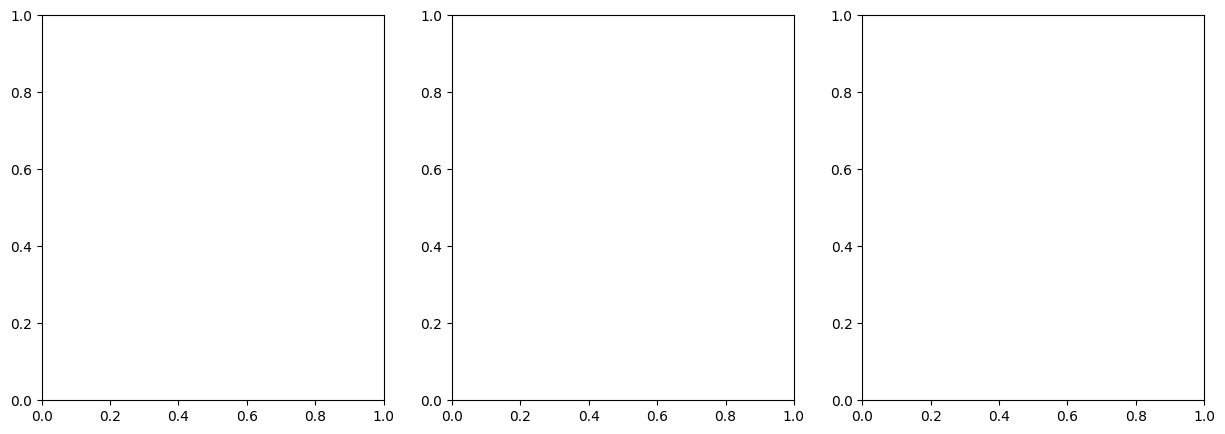

In [23]:
fig, ax = plt.subplots(figsize=(15, 5), ncols=3, nrows=1)
for i, (name, result_df) in enumerate(result_df_dict.items()):
    sns.kdeplot(data=result_df, 
                fill=True, 
                palette="crest", 
                common_grid=True, 
                cut=1, 
                ax=ax[i],
                )
    
    ax[i].set_title(name)